In [1]:
import numpy as np
import pandas as pd
import os
import io
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from google.colab import files

In [2]:
# Import training dataset 
uploaded = files.upload()

train_df = pd.read_csv(io.BytesIO(uploaded['Google_Stock_Price_Train.csv']))
train_df

Saving Google_Stock_Price_Train.csv to Google_Stock_Price_Train (4).csv


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [3]:
# Extract open column and conver to numpy array

train = train_df.iloc[:, 1:2].values
print(train)
print(train.shape)

[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]
(1258, 1)


In [4]:
# Feature Scaling
scale = MinMaxScaler(feature_range=(0,1))
train_scaled = scale.fit_transform(train)
train_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [5]:
# Modify dataset to make prediction using 60 timesteps
# 60 previous stock prices before the given day 
x_train = []
# Stock price of next day
y_train = []

for i in range(60,len(train_scaled)):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(1198, 60)
(1198,)


In [6]:
# Reshaping the dataset: data is 2D converting it to 3D tensor for training
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1198, 60, 1)

## Step 2: Building Stacked LSTM

In [7]:
model = Sequential()

# Add LSTM layer
model.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
# Add Regularization 
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Add output layer 
model.add(Dense(units = 1))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [9]:
# Compile the model 

model.compile(optimizer= 'adam',
             loss='mean_squared_error')

In [10]:
# Train the model 
model.fit(x_train, y_train, epochs = 100, batch_size= 32)

Epoch 1/100
38/38 [==============================] - 15s 29ms/step - loss: 0.0393
Epoch 2/100
38/38 [==============================] - 1s 23ms/step - loss: 0.0072
Epoch 3/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0064
Epoch 4/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0053
Epoch 5/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0054
Epoch 6/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 7/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0049
Epoch 8/100
38/38 [==============================] - 0s 13ms/step - loss: 0.0047
Epoch 9/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 10/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0042
Epoch 11/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0045
Epoch 12/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0042
Epoch 13/100
38/38 [====

In [11]:
uploaded = files.upload()
test_df = pd.read_csv(io.BytesIO(uploaded['Google_Stock_Price_Test.csv']))
test_df.head()

Saving Google_Stock_Price_Test.csv to Google_Stock_Price_Test (3).csv


,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [12]:
stock_price = test_df.iloc[:, 1:2].values

In [13]:
# Fetch 60 timesteps by combining train and test got prediction
total_df = pd.concat((train_df['Open'], test_df['Open']), axis = 0)
inputs = total_df[len(total_df) - len(test_df) -  60:].values
inputs = inputs.reshape(-1, 1)
inputs = scale.transform(inputs)

In [14]:
# Reshape the dataset

x_test = []

for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
#Predict stock for 2017
predicted_stock_price = model.predict(x_test)
predicted_stock_price

array([[0.95932984],
       [0.95461285],
       [0.95489526],
       [0.95692563],
       [0.962584  ],
       [0.97303784],
       [0.983096  ],
       [0.9881518 ],
       [0.9900979 ],
       [0.9905348 ],
       [0.99029386],
       [0.9895421 ],
       [0.98874116],
       [0.98920727],
       [0.9905671 ],
       [0.99858105],
       [1.0108632 ],
       [1.0246514 ],
       [1.0332102 ],
       [1.0277994 ]], dtype=float32)

In [16]:
predicted_stock_price = scale.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[794.8173 ],
       [792.2817 ],
       [792.4335 ],
       [793.5249 ],
       [796.56665],
       [802.1862 ],
       [807.5931 ],
       [810.31085],
       [811.357  ],
       [811.59186],
       [811.46234],
       [811.0582 ],
       [810.6277 ],
       [810.87823],
       [811.6092 ],
       [815.9172 ],
       [822.5196 ],
       [829.9316 ],
       [834.5324 ],
       [831.6238 ]], dtype=float32)

Visualization

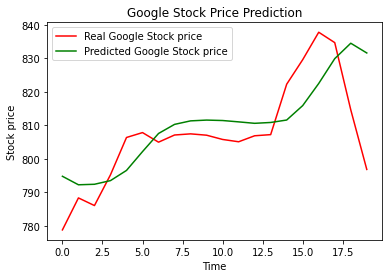

In [17]:
plt.plot(stock_price, color = 'red', label = 'Real Google Stock price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Google Stock price')
plt.title("Google Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()

### Model Evaluation

In [18]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(stock_price, predicted_stock_price))
print(f"Mean square error : {rmse}")

Mean square error : 11.731079220890463
